#### The biogeochemical model parameters identification (the biogeochemical model is in `brom_functions.py`)

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import brom_functions as bf
import plot_functions as pf
import lmfit as lf
import non_linear_fit_functions as lff

Open an initial dataset (observed values):

In [2]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()

In [3]:
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)

In [4]:
par = levelface['par'].values[0:365].astype(np.float64)
temperature = levelface['temperature'].values[0:365].astype(np.float64)
nh4_data = levelface['ammonium'].values[0:365].astype(np.float64)
no3_data = levelface['nitrate'].values[0:365].astype(np.float64)
po4_data = levelface['phosphate'].values[0:365].astype(np.float64)
si_data = levelface['silicate'].values[0:365].astype(np.float64)
o2_data = levelface['oxygen'].values[0:365].astype(np.float64)
chl_a_data = levelface['chl_a'].values[0:365].astype(np.float64)
om_flux = levelface['om_flux'].values[0:365].astype(np.float64)
irradiance = par*86400/1000000 # daily irradiance, convertion microM per second to M per day

There are some initial data:

In [5]:
#some common variables
depth = 0.625; k=0; latitude=54.88; days = np.arange(0,364,1)
#nutrients
nh4 = np.zeros(365); nh4[0] = nh4_data[0]
no2 = np.zeros(365); no2[0] = 0
no3 = np.zeros(365); no3[0] = no3_data[0] 
si = np.zeros(365); si[0] = si_data[0] 
po4 = np.zeros(365); po4[0] = po4_data[0] 
o2 = np.zeros(365); o2[0] = o2_data[0] 
#phy
phy = np.zeros(365); phy[0] = 1
# daily irradiance, convertion microM per second to M per day
irradiance = par*86400/1000000
#het
het = np.zeros(365); het[0] = 1
#om
pom = np.zeros(365); pom[0] = 100
dom = np.zeros(365); dom[0] = 50

There are some initial parameters (from the literature):

In [6]:
#horizontal advection
k_mix=900
#phy
knh4_lim=5; knox_lim=5; ksi_lim=0.1; kpo4_lim=0.1; pbm=3; alpha=0.075; kexc=0.015; kmortality=0.00001
#het
k_het_phy_gro=0.2; k_het_phy_lim=0.3; k_het_pom_gro=0.2; k_het_pom_lim=0.3
k_het_res=0.015; k_het_mort=0.1; uz=0.5; hz=0.5
#nitrification
k_nfix = 0.4; k_nitrif1=0.1; k_nitrif2=0.1; o2s_nf=5; k_anammox=0.8; o2s_dn=10
#om respiration
k_pom_dom=0.15; k_omox_o2=1; tref=0
k_dom_ox=0.1; k_pom_ox=0.002

Run a test simulation:

In [7]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, k_mix, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    nh4_data, no3_data, si_data, po4_data, o2_data,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    pom, dom, om_flux,
    k_pom_dom, k_omox_o2, tref, k_dom_ox, k_pom_ox)

The initial (with average parameters from the literature) chlorophyll a distribution, model vs data:

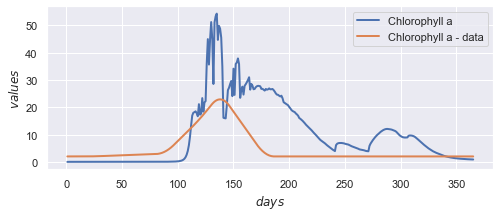

In [8]:
pf.plot_year_multi((chl_a,'Chlorophyll a'),(chl_a_data,'Chlorophyll a - data'))

Run the least squares to identify some parameters, a resudial function is constructed according to chl_a data.
This step was performed several times with different set of parameters.

In [9]:
params = lf.Parameters()
#horizontal advection
params.add('k_mix', value=k_mix, min=700, max=1100)
#phy
params.add('knh4_lim', value=knh4_lim, min=1, max=15)
params.add('knox_lim', value=knox_lim, min=1, max=15)
params.add('ksi_lim', value=ksi_lim, min=0.1)
params.add('kpo4_lim', value=kpo4_lim, min=0.1)
params.add('pbm', value=pbm, min=1, max=5)
params.add('alpha', value=alpha, min=0.05, max=0.09)
params.add('kexc', value=kexc, vary=False)
params.add('kmort', value=kmortality, vary=False)
#het
params.add('k_het_phy_gro', value=k_het_phy_gro, vary=False)
params.add('k_het_phy_lim', value=k_het_phy_lim, vary=False)
params.add('k_het_pom_gro', value=k_het_pom_gro, vary=False)
params.add('k_het_pom_lim', value=k_het_pom_lim, vary=False)
params.add('k_het_res', value=k_het_res, vary=False)
params.add('k_het_mort', value=k_het_mort, vary=False)
params.add('uz', value=uz, vary=False)
params.add('hz', value=hz, vary=False)
#nitrification
params.add('k_nfix', value=k_nfix, vary=False)
params.add('k_nitrif1', value=k_nitrif1, vary=False)
params.add('k_nitrif2', value=k_nitrif2, vary=False)
params.add('o2s_nf', value=o2s_nf, vary=False)
params.add('k_anammox', value=k_anammox, vary=False)
params.add('o2s_dn', value=o2s_dn,vary=False)
#OM
params.add('k_pom_dom', value=k_pom_dom, vary=False)
params.add('k_omox_o2', value=k_omox_o2, vary=False)
params.add('tref', value=tref, vary=False)
params.add('k_dom_ox', value=k_dom_ox, vary=False)
params.add('k_pom_ox', value=k_pom_ox, vary=False)

In [10]:
mini = lf.Minimizer(lff.residual_phy, params,
                    fcn_args=(depth, k, latitude, days, temperature,
                              nh4, no2, no3, si, po4, o2,
                              nh4_data, no3_data, si_data, po4_data, o2_data,
                              phy, par, irradiance,
                              het,
                              pom, dom, om_flux,
                              chl_a_data))

In [11]:
foo = lff.run_least_squares(mini)

Update the parameters with new values:

In [12]:
k_mix = lff.return_par_values(foo, 'k_mix')
knh4_lim = lff.return_par_values(foo, 'knh4_lim')
knox_lim = lff.return_par_values(foo, 'knox_lim')
ksi_lim = lff.return_par_values(foo, 'ksi_lim')
kpo4_lim = lff.return_par_values(foo, 'kpo4_lim')
pbm    = lff.return_par_values(foo, 'pbm')
alpha    = lff.return_par_values(foo, 'alpha')
k_het_phy_gro = lff.return_par_values(foo, 'k_het_phy_gro')
k_het_phy_lim = lff.return_par_values(foo, 'k_het_phy_lim')
k_het_pom_gro = lff.return_par_values(foo, 'k_het_pom_gro')
k_het_pom_lim = lff.return_par_values(foo, 'k_het_pom_lim')

In [13]:
print(k_mix)
print(knh4_lim); print(knox_lim);
print(ksi_lim); print(kpo4_lim)
print(pbm); print(alpha)
#print(k_het_phy_gro); print(k_het_phy_lim)
#print(k_het_pom_gro); print(k_het_pom_lim)

704.256791921495
6.8900870489502735
14.753508524562498
0.1
0.1
2.7269642192296613
0.0884237333891914


Run the model with the new parameters' values:

In [14]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, k_mix, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    nh4_data, no3_data, si_data, po4_data, o2_data,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    pom, dom, om_flux, 
    k_pom_dom, k_omox_o2, tref, k_dom_ox, k_pom_ox)

Chlorophyll a distribution, model vs data (with some parameters established with LMFIT):

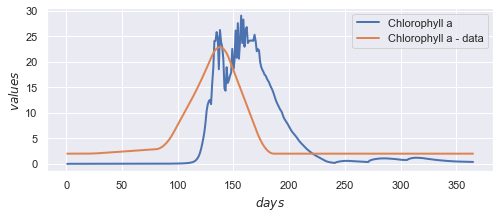

In [15]:
pf.plot_year_multi((chl_a,'Chlorophyll a'),(chl_a_data,'Chlorophyll a - data'))